In [16]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [17]:
df = pd.read_csv('./results/opencv-20220411-210345.tsv', sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/opencv-20220411-210345-ap.tsv', sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/opencv-20220411-210345-load.tsv', sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/opencv-20220411-210345-metadata.tsv', sep='\t', header=0)

In [18]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [19]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-11 21:03:45.649107,3.6,6400794624
1,2022-04-11 21:03:56.681541,50.6,5801222144
2,2022-04-11 21:04:07.772540,58.5,5655969792
3,2022-04-11 21:04:18.822041,51.8,5595844608
4,2022-04-11 21:04:29.891040,51.1,5640179712
5,2022-04-11 21:04:40.941041,50.9,5630648320
6,2022-04-11 21:04:51.978042,53.6,5627322368
7,2022-04-11 21:05:03.192540,48.1,5626896384
8,2022-04-11 21:05:14.216540,51.0,5628436480
9,2022-04-11 21:05:25.220041,49.0,5538471936


In [20]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

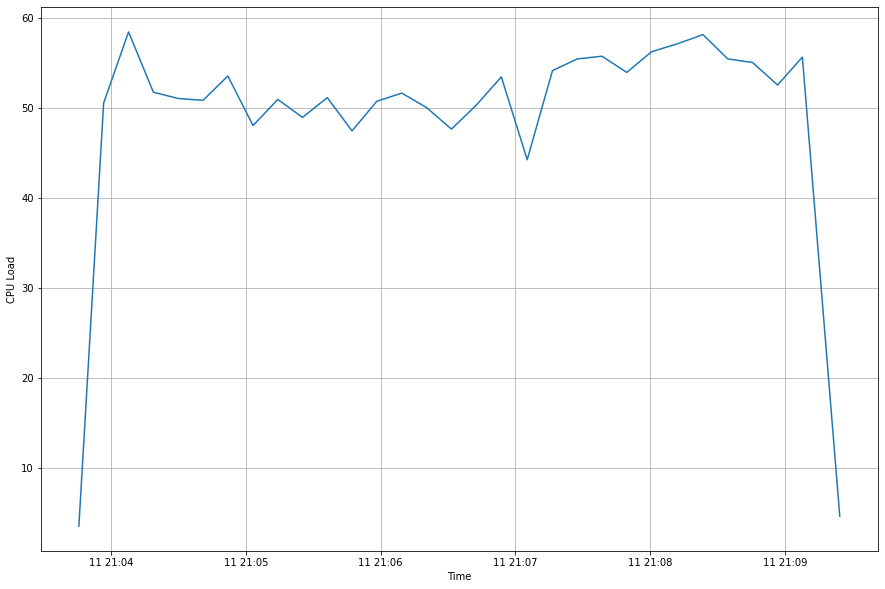

In [21]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

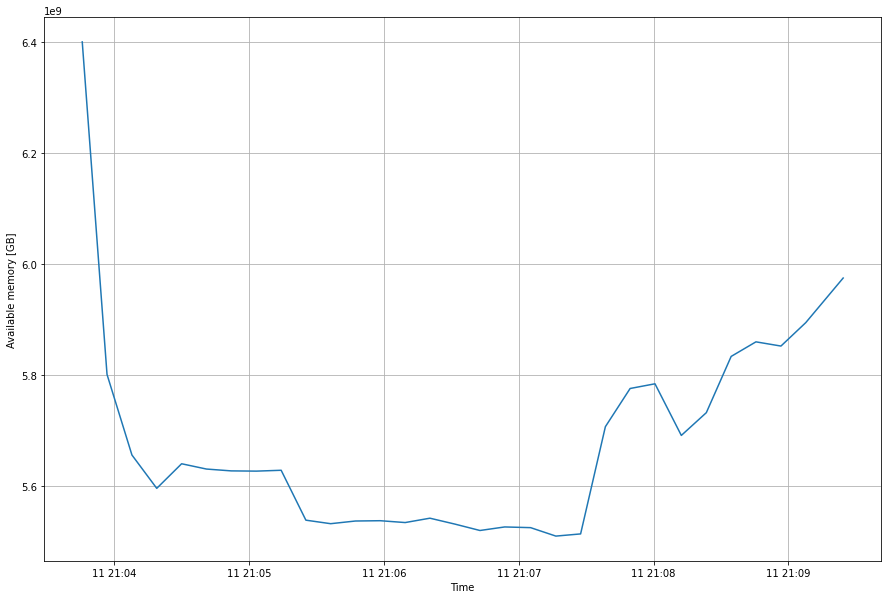

In [22]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

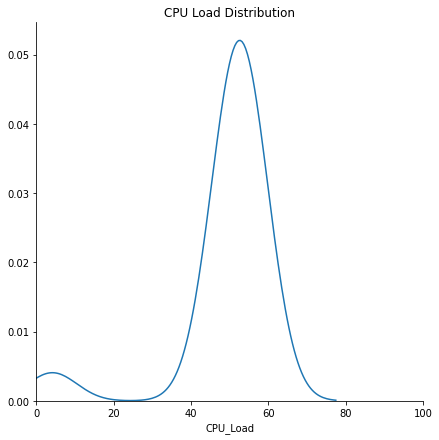

In [23]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

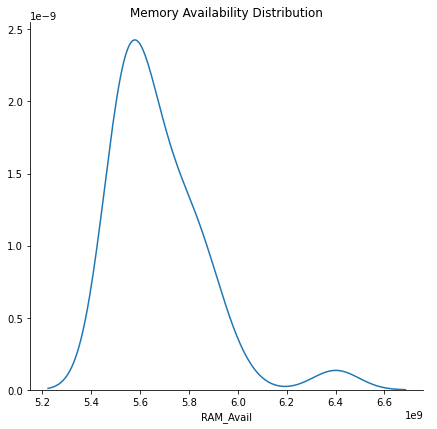

In [24]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [25]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-11 21:03:46.336041,244804200,0.750000,0.37500,0.500000,"[0.6699566160520607, 0.7114774889029803, 0.044...",3,1,5,8,"[(770.0, 196.0, 857.0, 283.0), (298.0, 156.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-11 21:03:46.432040,89491000,0.000000,0.00000,0.000000,[0.0],0,1,1,1,"[(417.0, 714.0, 737.0, 1034.0)]","[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-11 21:03:46.520541,80984100,0.333333,0.50000,0.400000,"[0.6550373798504806, 0.0, 0.0]",1,2,1,2,"[(449.0, 40.0, 502.0, 93.0), (684.0, 322.0, 78...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-11 21:03:46.695041,92779900,0.000000,0.00000,0.000000,[],0,0,62,62,[],"[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-11 21:03:46.773540,59432000,0.833333,0.62500,0.714286,"[0.6420729029424681, 0.07943482963764197, 0.62...",5,1,3,8,"[(720.0, 63.0, 767.0, 110.0), (172.0, 6.0, 344...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-11 21:09:13.999540,134013700,1.000000,1.00000,1.000000,[0.6655021834061136],1,0,0,1,"[(460.0, 153.0, 622.0, 315.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-11 21:09:14.148041,140428400,1.000000,0.50000,0.666667,[0.6259521218715995],1,0,1,2,"[(690.0, 412.0, 808.0, 530.0)]","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-11 21:09:14.303040,87370400,0.850000,0.62963,0.723404,"[0.65625, 0.4759071980963712, 0.74074074074074...",17,3,10,27,"[(541.0, 379.0, 581.0, 419.0), (573.0, 319.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-11 21:09:14.366542,50780400,0.000000,0.00000,0.000000,[0.0],0,1,7,7,"[(290.0, 199.0, 393.0, 302.0)]","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [26]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,7.878124e+07,0.441442,0.369290,0.352702,1.584315,0.799752,10.724427,12.308741
std,3.276629e+07,0.427880,0.419222,0.377597,3.098665,1.110156,39.588112,39.822258
min,1.723780e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.798128e+07,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,7.327160e+07,0.500000,0.148148,0.247449,1.000000,0.000000,2.000000,3.000000
75%,9.109695e+07,1.000000,0.951766,0.666667,2.000000,1.000000,7.000000,9.000000
max,5.891056e+08,1.000000,1.000000,1.000000,37.000000,10.000000,709.000000,709.000000


In [27]:
df_ap

,Confidence,TP_FP
0,69,TP
1,11,TP
2,12,FP
3,51,TP
4,10,FP
...,...,...
7686,13,TP
7687,17,TP
7688,14,TP
7689,16,TP


In [28]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [29]:
df_ap

,Confidence,TP_FP,Precision,Recall
0,69,TP,1.000000,0.000025
1,11,TP,1.000000,0.000050
2,12,FP,0.666667,0.000050
3,51,TP,0.750000,0.000076
4,10,FP,0.600000,0.000076
...,...,...,...,...
7686,13,TP,0.664499,0.128639
7687,17,TP,0.664542,0.128664
7688,14,TP,0.664586,0.128689
7689,16,TP,0.664629,0.128715


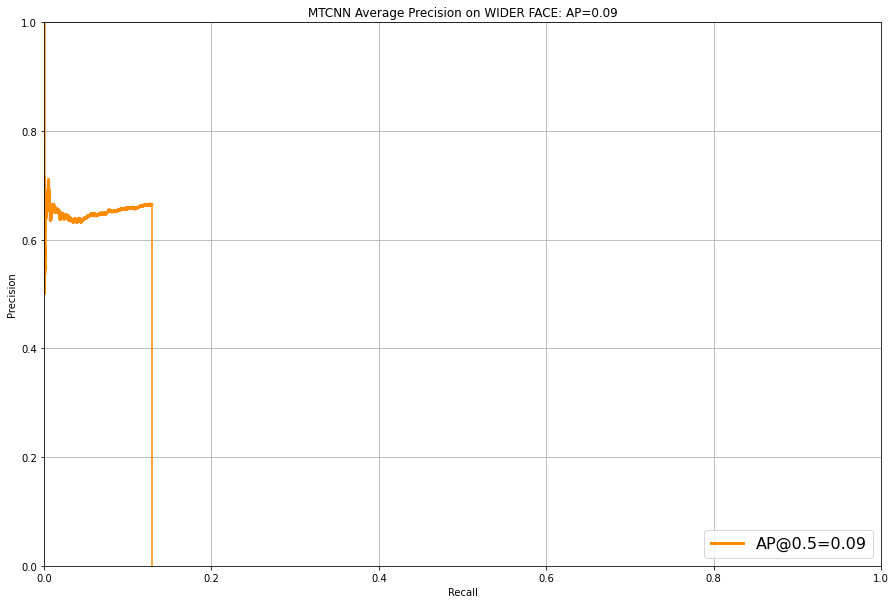

In [30]:
ap = calc_ap(df_ap)

plt.plot(df_ap['Recall'], df_ap['Precision'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
plt.axvline(x = df_ap['Recall'][df_ap.index[-1]], ymax=df_ap['Precision'][df_ap.index[-1]], color = "darkorange")
plt.xlim(0, 1.00)
plt.ylim(0, 1.00)

plt.title('MTCNN Average Precision on WIDER FACE: AP=%.2f' % ap)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right", prop={'size': 16})
plt.grid(True)

plt.show()